# Import Libraries

In [ ]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

import tensorflow.keras
from keras.layers import Dense
from keras.models import Sequential
import numpy as np

from keras import optimizers
from tensorflow.keras import regularizers
from keras import regularizers
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D
from keras.models import Sequential 
from keras.layers import Dense, Conv2D, Flatten,MaxPool2D
import random

import matplotlib.pyplot as plt

from skimage.io import concatenate_images
from skimage.transform import resize
from sklearn.model_selection import train_test_split, KFold

from keras.models import Model
from keras.layers import Input, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

No. of images =  433


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/433 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Done!


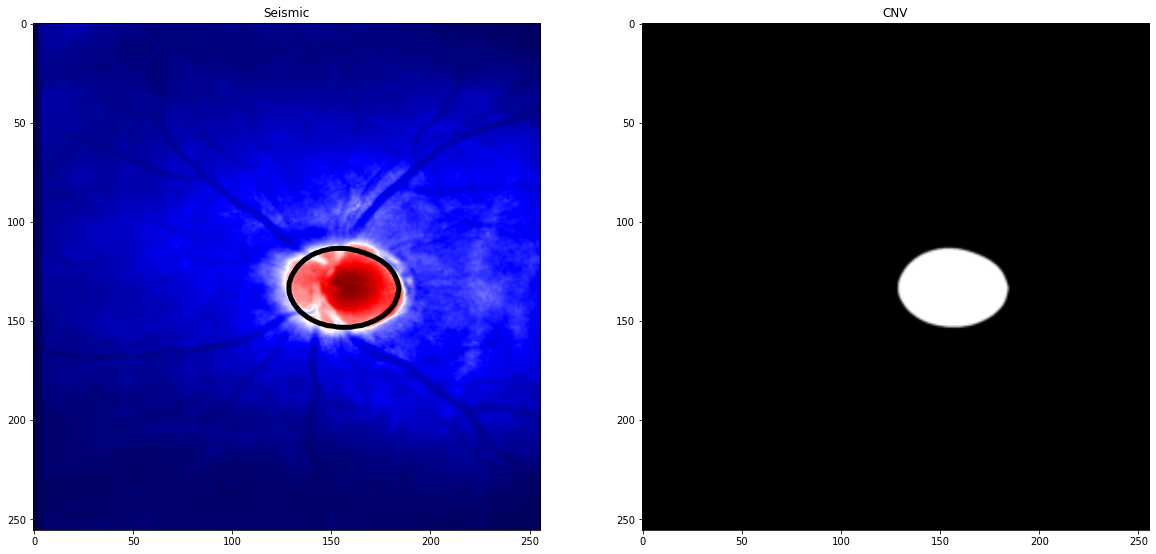

In [ ]:
# Set some parameters
#BATCH_SIZE = 5
im_width = 256
im_height = 256
border = 5

images='/.../FundasDataset/AllImage/'

ids = next(os.walk(images))[2] # list of names all images in the given path
 
print("No. of images = ", len(ids))
X = np.zeros((len(ids), im_height, im_width, 3), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img(images+id_)
    x_img = img_to_array(img)
    x_img = resize(x_img, (256, 256, 3), mode = 'constant', preserve_range = True)
    # Load masks
    masks='/.../FundasDataset/AllMasks/'
    mask = img_to_array(load_img(masks+id_,grayscale=True))
    mask = resize(mask, (256, 256, 1), mode = 'constant', preserve_range = True)
    # Save images
    #### Normalized data
    X[n] = x_img/255.0
    y[n] = mask/255.0
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # cnv indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if cnv
    # draw a boundary(contour) in the original image separating cnv and non-cnv areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Seismic')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('CNV')

print('Done!')


# Data Augmentation 

In [ ]:
seed=42
def get_train_test_augmented(X_data=X_train, Y_data=y_train, validation_split=0.1, batch_size=32, seed=seed):
    X_train, X_test, Y_train, Y_test = train_test_split(X_data,
                                                        Y_data,
                                                        train_size=1-validation_split,
                                                        test_size=validation_split,
                                                        random_state=seed)
    
 # Image data generator distortion options
    data_gen_args = dict(rotation_range=10,
                         width_shift_range=0.05,
                         height_shift_range=0.05,
                         shear_range=0.4,
                         zoom_range=0.4,
                         horizontal_flip=True,
                         vertical_flip=True,
                         #brightness_range=[0.4,1.2],
                         fill_mode='reflect')  #use 'constant'??

# Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)
    Y_datagen.fit(Y_train, augment=True, seed=seed)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)

 # Test data, no data augmentation, but we create a generator anyway
    X_datagen_val = ImageDataGenerator()
    Y_datagen_val = ImageDataGenerator()
    X_datagen_val.fit(X_test, augment=True, seed=seed)
    Y_datagen_val.fit(Y_test, augment=True, seed=seed)
    X_test_augmented = X_datagen_val.flow(X_test, batch_size=batch_size, shuffle=True, seed=seed)
    Y_test_augmented = Y_datagen_val.flow(Y_test, batch_size=batch_size, shuffle=True, seed=seed)
    
    
    # combine generators into one which yields image and masks
    train_generator = zip(X_train_augmented, Y_train_augmented)
    test_generator = zip(X_test_augmented, Y_test_augmented)
    
    return train_generator, test_generator

In [ ]:
def dice_coef(y_pred, y_true):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 0.0001) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.0001)


def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


# U-net Network

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    

    return x
def get_unet(input_img, n_filters = 16, dropout = 0.2, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    #Bottle necK
    ## 
    c5 = conv2d_block(p4, n_filters = n_filters * 32, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    #fully connected 
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model


# Training Models

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  896         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 256, 256, 32  128        ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 0.5799 - accuracy: 0.8773 - dice_coef: 0.4204
Epoch 1: val_loss improved from inf to 0.76343, saving model to /content/drive/My Drive/savemymodel/model-optic-disc.h5
195/195 [==============================] - 137s 636ms/step - loss: 0.5799 - accuracy: 0.8773 - dice_coef: 0.4204 - val_loss: 0.7634 - val_accuracy: 0.4760 - val_dice_coef: 0.2422 - lr: 0.0010
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 0.2856 - accuracy: 0.9599 - dice_coef: 0.7142
Epoch 2: val_loss improved from 0.76343 to 0.51678, saving model to /content/drive/My Drive/savemymodel/model-optic-disc.h5
195/195 [==============================] - 121s 622ms/step - loss: 0.2856 - accuracy: 0.9599 - dice_coef: 0.7142 - val_loss: 0.5168 - val_accuracy: 0.8311 - val_dice_coef: 0.4799 - lr: 0.0010
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 0.2098 - accuracy: 0.9677 - dice_coef: 0.7900
Epoch 3: val_loss improv

OSError: ignored

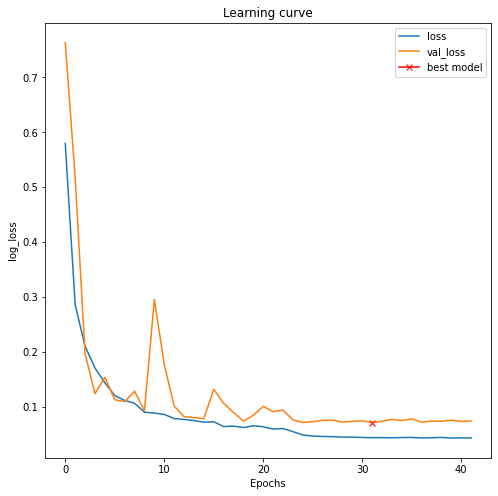

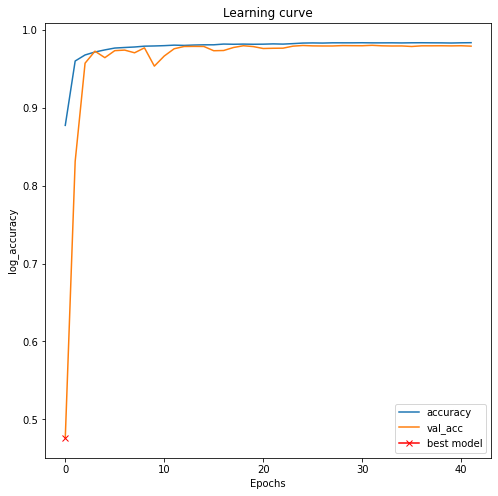

In [ ]:
from keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from keras.backend import minimum, maximum
def dice_coef(y_pred, y_true):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 0.0001) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.0001)


def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

input_img = Input((im_height, im_width, 3), name='img')

def my_loss(y_true, y_pred):
  layer_names = [layer.name for layer in model.layers]
  for l in layer_names:
    if l==layer_names[-1]:
      value = TV_bin_loss(y_true, y_pred)
    else:
      value = binary_crossentropy(K.flatten(y_true),K.flatten(y_pred))
  return value


input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=32, dropout=0.2, batchnorm=True)
model.compile(optimizer=Adam(), loss=dice_loss, metrics=['accuracy',dice_coef])
model.summary()

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('/content/drive/My Drive/savemymodel/model-optic-disc.h5', verbose=1, save_best_only=True, save_weights_only=True)
]


batch_size = 32
valid_steps = X_valid.shape[0]//batch_size + 1
train_steps = X_train.shape[0]//batch_size + 1

train_generator, test_generator = get_train_test_augmented(X_data=X_train, Y_data=y_train, validation_split=0.11, batch_size=batch_size)
results = model.fit_generator(train_generator, 
                     validation_data=test_generator, 
                     validation_steps=batch_size/2, 
                     steps_per_epoch=195, 
                     epochs=50, callbacks=callbacks)


plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_acc")
plt.plot( np.argmin(results.history["val_accuracy"]), np.min(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_accuracy")
plt.legend();


# load the best model
model.save('/.../savemymodel/opticdiscseg_model.h5')
model.load_weights('/.../savemymodel/model-optic-disk.h5')
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('CNV')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('CNV Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('CNV Predicted binary');

# Check if training data looks all right
for ix in range (4):
     plot_sample(X_train, y_train, preds_train, preds_train_t, ix)
     plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix)

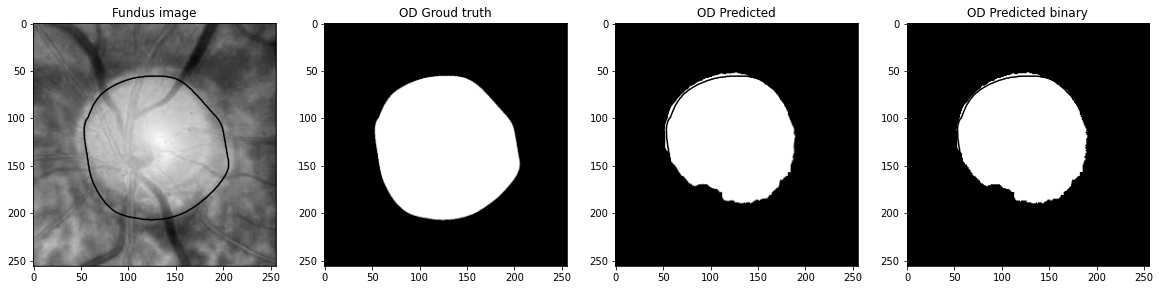

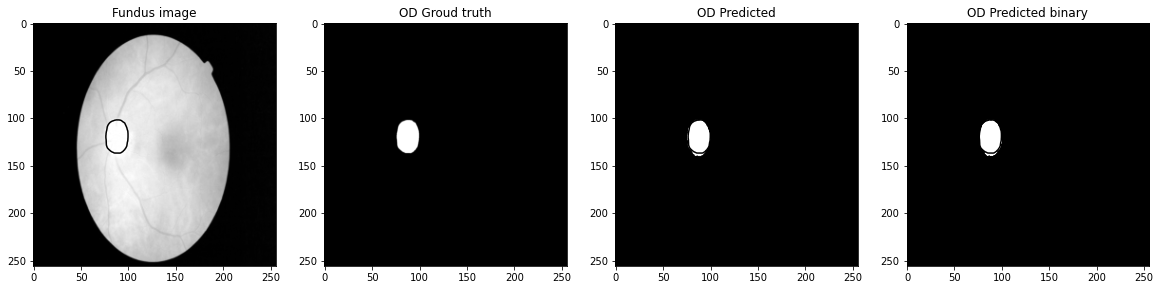

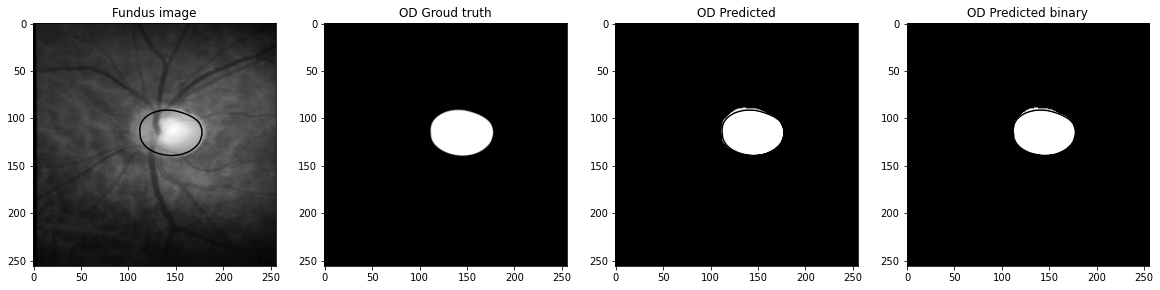

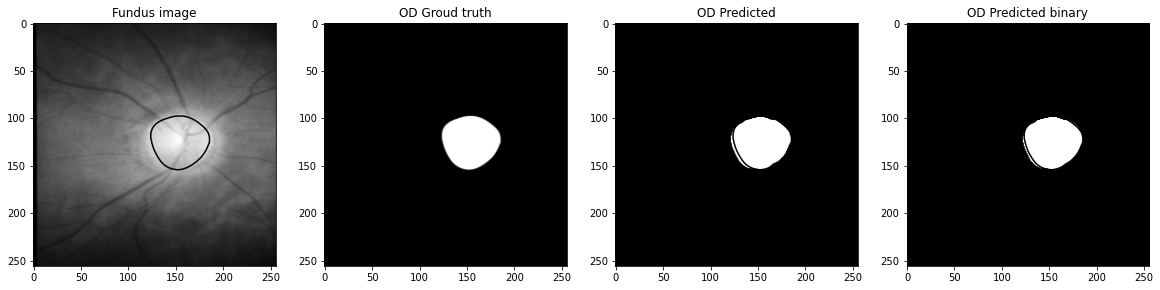

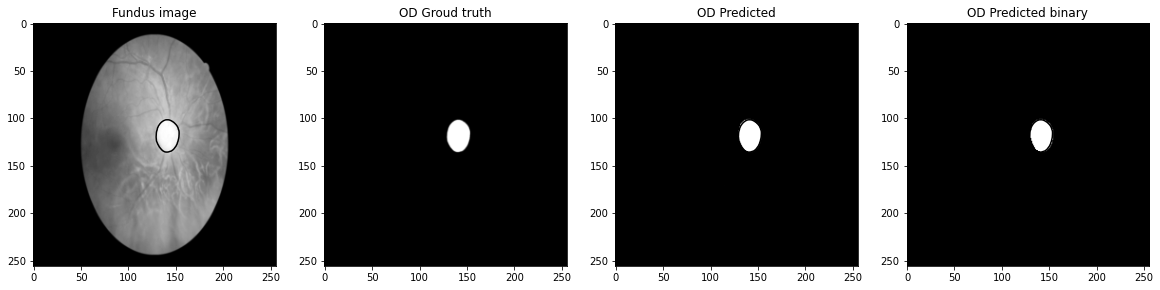

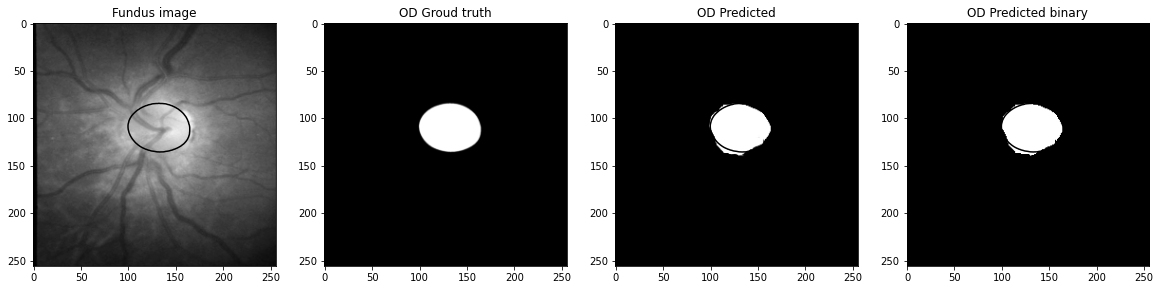

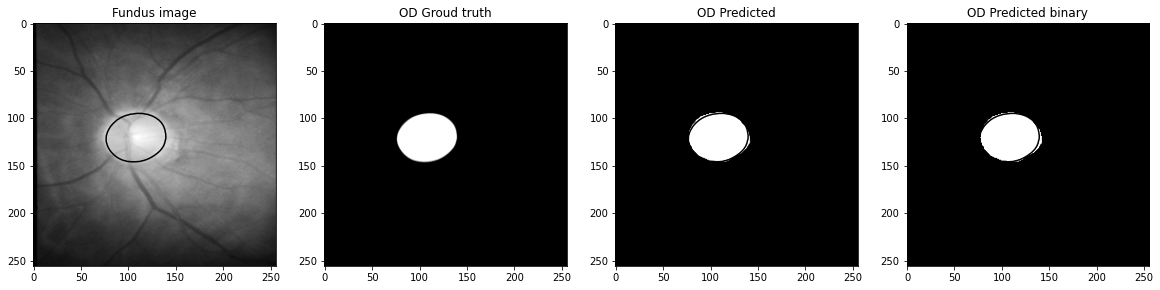

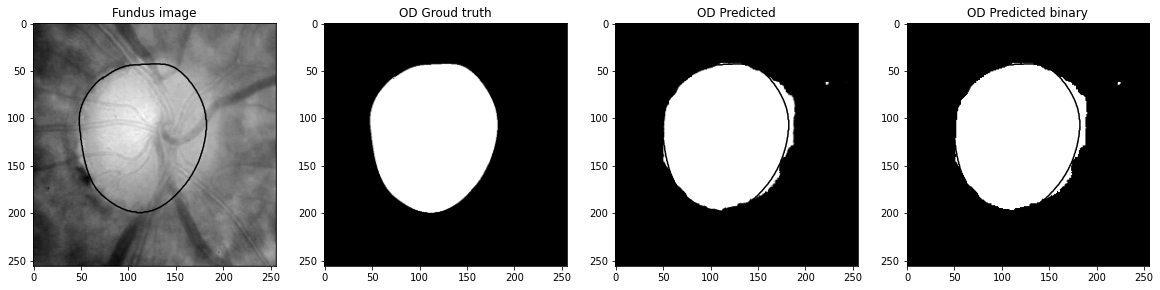

In [ ]:

def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Fundus image')

    ax[1].imshow(y[ix].squeeze(),cmap='gray')
    ax[1].set_title('OD Groud truth')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1,cmap='gray')
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('OD Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1,cmap='gray')
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k',levels=[0.5])
    ax[3].set_title('OD Predicted binary');

# Check if training data looks all right
for ix in range (4):
     plot_sample(X_train, y_train, preds_train, preds_train_t, ix)
     plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix)